In [2]:
from utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
def custom_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return custom_score(y.to_numpy(), y_prob, num_features=X.shape[1], top_k_reference=1000)

In [10]:
def plot_distirbution(y_pred):
    y_pred_sorted = np.sort(y_pred)
    top_1000_threshold = y_pred_sorted[-1000]
    
    
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_sorted, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
    plt.axvline(x=top_1000_threshold, color='green', linestyle='--', label='Top 1000 threshold')
    
    plt.title('Probability distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count (bin)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def metrics_top_and_global(y_true, y_prob, num_features=2,top_k=1000):
    
    score= custom_score(y_true, y_prob, num_features=num_features, top_k_reference=top_k)
    logloss = log_loss(y_true, y_prob)
    
    
    top_k_idx = np.argsort(y_prob)[-top_k:]
    y_true_top = y_true[top_k_idx]
    y_pred_top = (y_prob[top_k_idx] >= 0.5).astype(int)
    acc_top = np.mean(y_true_top == y_pred_top)

    y_pred_all = (y_prob >= 0.5).astype(int)
    acc_global = np.mean(y_true == y_pred_all)
    logloss_top = log_loss(y_true[top_k_idx], y_prob[top_k_idx])

    return {
        "score": score,
        "acc_top": acc_top,
        "acc_global": acc_global,
        "logloss_top": logloss_top,
        "logloss_global": logloss
    }


In [5]:
def evaluate_model_with_gridsearch(model, param_grid, X, y, X_test, n_splits=5, num_features=2,top_k=1000):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={"clf__" + k: v for k, v in param_grid.items()},
        cv=skf,
        scoring=custom_scorer,
        n_jobs=-1
    )

    grid.fit(X, y)
    best_model = grid.best_estimator_
    y_prob_all = cross_val_predict(best_model, X, y, cv=skf, method="predict_proba")[:, 1]
    metrics = metrics_top_and_global(y.to_numpy(), y_prob_all, num_features, top_k)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    plot_distirbution(y_pred)
    
    return best_model, grid.best_score_, grid.best_params_, metrics


In [6]:
models_params = {
    "Logistic Regression": (
        LogisticRegression(max_iter=2000),
        {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "penalty": ["l2"],
            "solver": ["lbfgs", "liblinear"]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200, 500],
            "max_depth": [None, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2"]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    ),
    "SVC": (
        SVC(probability=True),
        {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    ),
    "Naive Bayes": (
        GaussianNB(),
        {}
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    )
}


### 2 features

In [7]:
X = pd.read_csv('../data_after_processing/col0_col2.csv')
y = X['col500']
X = X.drop(columns=['col500'])

In [8]:
X_test = load_data('../data/x_test.txt')
X_test.columns = [f'col{i}' for i in range(len(X_test.columns))]
X_test = X_test[X.columns]

Testing: Logistic Regression


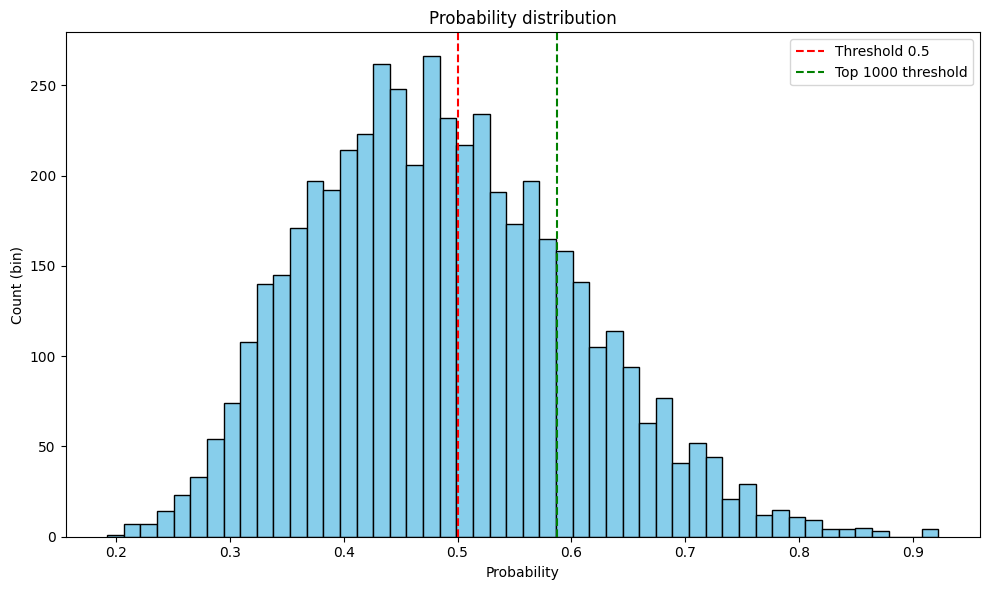

Logistic Regression: 6920.0000
   Parameters: {'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

   Metrics: {'score': np.float64(6920.0), 'acc_top': np.float64(0.732), 'acc_global': np.float64(0.6786), 'logloss_top': 0.601817417744516, 'logloss_global': 0.6347676678518155}

Testing: Random Forest


In [ ]:
results = []

for name, (model, param_grid) in models_params.items():
    print(f"Testing: {name}")
    best_model, best_score, best_params, metrics = evaluate_model_with_gridsearch(
        model, param_grid, X, y, X_test, n_splits=5, num_features=2, top_k=1000
    )
    results.append((name, best_score, best_params, metrics))
    print(f"{name}: {best_score:.4f}")
    print(f"   Parameters: {best_params}\n")  
    print(f"   Metrics: {metrics}\n")


### 5 features

In [3]:
X = pd.read_csv('../data_after_processing/step_by_step_5_features.csv')
y = X['col500']
X = X.drop(columns=['col500'])

In [22]:
results = []

for name, (model, param_grid) in models_params.items():
    print(f"Testing: {name}")
    best_model, best_score, best_params, metrics = evaluate_model_with_gridsearch(
        model, param_grid, X, y, n_splits=5, num_features=5, top_k=1000
    )
    results.append((name, best_score, best_params, metrics))
    print(f"{name}: {best_score:.4f}")
    print(f"   Parameters: {best_params}\n")
    print(f"   Metrics: {metrics}\n")


Testing: Logistic Regression
Logistic Regression: 6280.0000
   Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

   Metrics: {'score': np.float64(6260.0), 'acc_top': np.float64(0.726), 'acc_global': np.float64(0.7114)}

Testing: Random Forest
Random Forest: 6510.0000
   Parameters: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}

   Metrics: {'score': np.float64(6390.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.7094)}

Testing: Gradient Boosting
Gradient Boosting: 6410.0000
   Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__subsample': 1.0}

   Metrics: {'score': np.float64(6390.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.7118)}

Testing: XGBoost
XGBoost: 6450.0000
   Parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsamp

### Probability distribution 

In [9]:
X_test = load_data('../data/x_test.txt')
X_test.columns = [f'col{i}' for i in range(len(X_test.columns))]
X_test = X_test[X.columns]

In [10]:
rfik = RandomForestClassifier(max_depth = None, max_features = 'log2', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100)

In [11]:
rfik.fit(X, y)

RandomForestClassifier(max_features='log2', min_samples_split=10)

In [18]:
y_pred = rfik.predict_proba(X_test)[:, 1]